In [90]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import csv
import cv2
import glob
import networkx as nx
from tqdm import tqdm
from enum import Enum
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import xml.etree.ElementTree as et 
from gym.envs.hyrule.hyrule_env import Manifest

In [76]:
pano_path = "data/equirectangular"
crop_path = "data/reduced_fps"
pano_hdf_path = pano_path + "/manifest.hdf5"
crop_hdf_path = crop_path + "/manifest.hdf5"

In [3]:
paths = glob.glob("data/equirectangular/labels/*.xml")

/Users/martinweiss/.pyenv/versions/3.5.2/lib/python3.5/site-packages/pandas/core/generic.py:1996: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->['obj_type', 'house_number', 'coords']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [107]:
path="data/equirectangular/"
hdf_path="data/equirectangular/manifest.hdf5"

In [117]:
manifest = Manifest(path, hdf_path)

In [116]:
# manifest.df['frame']
# manifest.df.to_hdf(hdf_path, key="df", index=False)

In [ ]:
mani

In [7]:
# threedee = plt.figure().gca(projection='3d')
# threedee.scatter(manifest.df.x, manifest.df.y, manifest.df.z)


In [9]:
G = nx.Graph()
G.add_nodes_from(manifest.df.index)
max_node_distance = 10
pos = {}
edge_pos = []
for node1 in G.nodes:
    meta = manifest.df.iloc[node1]
    coords1 = np.array([meta['x'], meta['y'], meta['z']])
    G.nodes[node1]['coords'] = coords1
    G.nodes[node1]['camera'] = meta['camera']
    G.nodes[node1]['frame'] = meta['frame'] if meta['frame'] != -1 else node1
    pos[node1] = coords1
    for node2 in G.nodes:
        if node1 == node2:
            continue
        meta2 = manifest.df.iloc[node2]
        coords2 = np.array([meta2['x'], meta2['y'], meta2['z']])
        G.nodes[node2]['coords'] = coords2
        if np.linalg.norm(coords1 - coords2) < max_node_distance:
            edge_pos.append((coords1, coords2))
            G.add_edge(node1, node2, weight=np.linalg.norm(coords1-coords2))

In [10]:
start_node = np.random.choice(len(G.nodes))
cur_node = start_node
edges = [edge[1] for edge in list(G.edges(cur_node))]
next_node = np.random.choice(edges)

In [11]:
pos = {k: v[0:2] for k, v in pos.items()}

/Users/martinweiss/miniconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


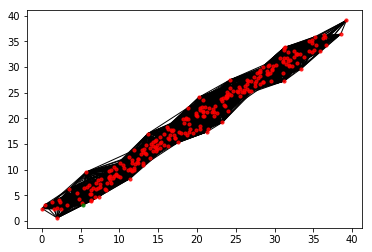

In [12]:
nx.draw_networkx_nodes(G, pos,
                       nodelist=G.nodes - {cur_node},
                       node_color='r',
                       node_size=10,
                   alpha=0.8)
nx.draw_networkx_nodes(G, pos,
                       nodelist={cur_node},
                       node_color='g',
                       node_size=10,
                   alpha=0.8)
edges = nx.draw_networkx_edges(G, pos=pos)


In [78]:
for e in G.edges(cur_node):
    camera = G.nodes[e[1]]['camera']
    get_direction(camera)

3
4
8
2
6
2


In [67]:
class Direction(Enum):
    FORWARD = auto()
    RIGHT = auto()
    BACKWARD = auto()
    LEFT = auto()



In [70]:
def get_direction(i):
    if i == 0 or i == 1:
        print(Direction.FORWARD)
    if i == 2 or i == 3:
        print(Direction.RIGHT)
    if i == 4 or i == 5:
        print(Direction.LEFT)
    if i == 6 or i == 7:
        print(Direction.BACKWARD)


Direction.RIGHT


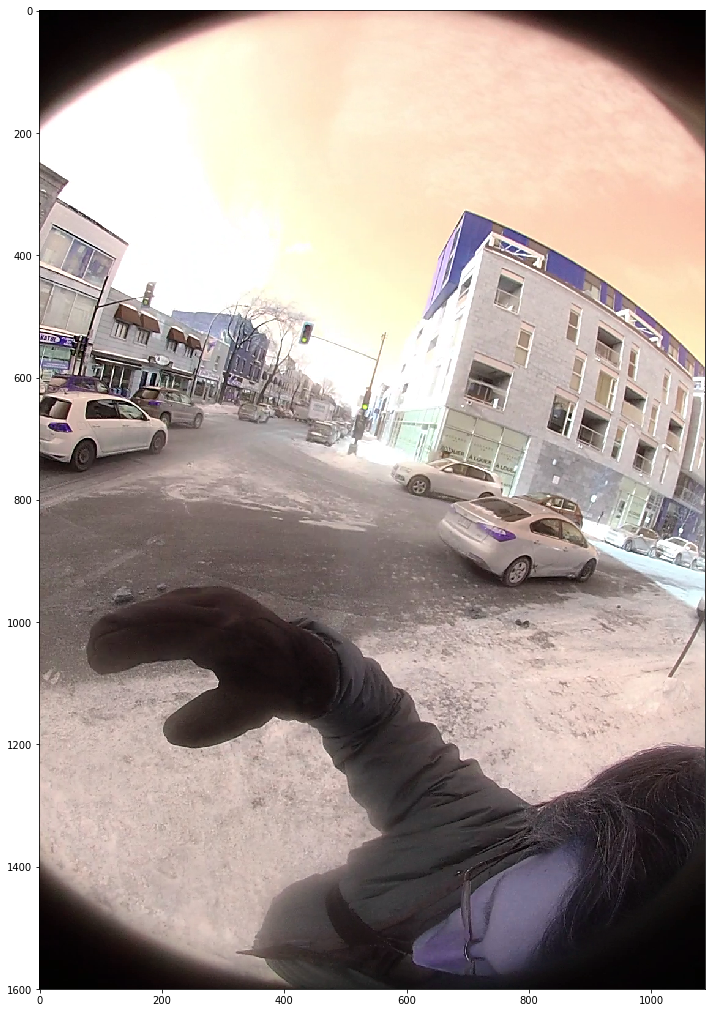

camera: 3
Direction.RIGHT


In [74]:
meta = crop_manifest.df.iloc[cur_node]
obs = cv2.imread(meta['path'])
fig, ax = plt.subplots(figsize=(18, 18))
ax.imshow(obs)
plt.show()
camera = G.nodes[cur_node]["camera"]
print("camera: " + str(camera))
get_direction(camera)


In [29]:
# Graph
# [Nodes]
# [Edges]

# Edge
  # Angle
 
# Node (one row in manifest)
  # Spatial coordinates
  # [Images]
  # [Depth Maps]
  # Angle
  # [Edges]
  # Date

# Image (class)
  # data
  # date
  

# Panorama (subclass of image)

# Crop (subclass of image)

# Agent (class)
    # Train function
    # cmdline args
    

# Action (enum)

In [ ]:
class ImageDataset(Dataset):
    """Image dataset."""

    def __init__(self, hdf_path, transform=None):
        self.manifest = pd.read_hdf(hdf_path, index_col=False)

    def __len__(self):
        return len(self.manifest)

    def __getitem__(self, idx):
        image = cv2.imread(self.manifest['image_path'][idx])
        sample = {'image': image, 'meta': self.manifest.iloc[idx]}
        return sample
